In [1]:
include("../scripts/mcl.jl")

draw (generic function with 7 methods)

In [2]:
function sigma_ellipse(p, cov, n)
    eig_vals= eigvals(cov)
    eig_vec = eigvecs(cov)
    ang = atan(eig_vec[1,:][2], eig_vec[1,:][1])/pi * 180
    return patches.Ellipse(p, width=2*n*sqrt(eig_vals[1]), 
        height=2*n*sqrt(eig_vals[2]), angle=ang, fill=false, color="blue", alpha=0.5)
end

sigma_ellipse (generic function with 1 method)

In [3]:
function matM(nu, omega, time, stds)
    return Diagonal([stds["nn"]^2*abs(nu)/time + stds["no"]^2*abs(omega)/time,
            stds["on"]^2*abs(nu)/time + stds["oo"]^2*abs(omega)/time])
end

matM (generic function with 1 method)

In [4]:
function matA(nu, omega, time, theta)
    st, ct = sin(theta), cos(theta)
    stw, ctw = sin(theta+omega*time), cos(theta+omega*time)
    return [(stw-st)/omega -nu/(omega^2)*(stw-st)+nu/omega*time*ctw;
                 (-ctw+ct)/omega -nu/(omega^2)*(-ctw+ct)+nu/omega*time*stw;
                 0.0 time]
end

matA (generic function with 1 method)

In [5]:
function matF(nu, omega, time, theta)
    F = [1.0 0.0 0.0;0.0 1.0 0.0; 0.0 0.0 1.0]
    F[1, 3] = nu / omega * (cos(theta + omega * time) - cos(theta))
    F[2, 3] = nu / omega * (sin(theta + omega * time) - sin(theta))
    return F
end

matF (generic function with 1 method)

In [6]:
function matH(pose, landmark_pos)
    mx, my = landmark_pos
    mux, muy, mut = pose
    q = (mux - mx)^2 + (muy- my)^2
    return [(mux - mx)/sqrt(q) (muy-my)/sqrt(q) 0.0; (my-muy)/q (mux-mx)/q -1.0]
end

matH (generic function with 1 method)

In [7]:
function matQ(distance_dev, direction_dev)
    return Diagonal([distance_dev^2, direction_dev^2])
end

matQ (generic function with 1 method)

In [8]:
mutable struct KalmanFilter
    belief
    pose
    motion_noise_stds
    map
    distance_dev_rate
    direction_dev
end

In [9]:
function KalmanFilter_(envmap, init_pose, motion_noise_stds=Dict("nn"=>0.19, "no"=>0.001, "on"=>0.13, "oo"=>0.2),
                distance_dev_rate=0.14, direction_dev=0.05)
    self = KalmanFilter(ntuple(x->nothing, fieldcount(KalmanFilter))...)
    self.belief = MvNormal([0.0,0.0, 0.0], Diagonal([1e-10, 1e-10, 1e-10]))
    self.pose = self.belief.μ
    self.motion_noise_stds = motion_noise_stds
    self.map = envmap
    self.distance_dev_rate = distance_dev_rate
    self.direction_dev = direction_dev
    return self
end

KalmanFilter_ (generic function with 4 methods)

In [10]:
function motion_update(self::KalmanFilter, nu, omega, time)
    if abs(omega) < 1e-5
        omega = 1e-5
    end
    
    M = matM(nu, omega, time, self.motion_noise_stds)
    A = matA(nu, omega, time, self.belief.μ[3])
    F = matF(nu, omega, time, self.belief.μ[3])
    n_cov = F*self.belief.Σ*F' + A*M*A'
    n_mean = state_transition(IdealRobot(), nu, omega, time, self.belief.μ)
    self.belief = MvNormal(n_mean, Symmetric(n_cov))
    self.pose = self.belief.μ
end

motion_update (generic function with 3 methods)

In [21]:
function observation_update(self::KalmanFilter, observation)
    for d in observation
        z = d[1]
        obs_id = d[2]+1 #1indexed
        H = matH(self.belief.μ, self.map.landmarks[obs_id].pos)
        estimated_z = relative_polar_pos(IdealCamera(), self.belief.μ, self.map.landmarks[obs_id].pos)
        Q = matQ(estimated_z[1]*self.distance_dev_rate, self.direction_dev)
        K = self.belief.Σ * H' * inv(Q + H * self.belief.Σ * H')
        n_cov = (Matrix{Float64}(I, 3, 3) - K * H ) * self.belief.Σ
        n_mean = self.belief.μ + K * (z - estimated_z)
        self.belief = MvNormal(n_mean, Symmetric(n_cov))
        self.pose = self.belief.μ
    end
end

observation_update (generic function with 3 methods)

In [22]:
function draw(self::KalmanFilter, ax, elems)
    e = sigma_ellipse(self.belief.μ[1:2], self.belief.Σ[1:2, 1:2], 3)
    elems = vcat(elems, [ax.add_patch(e)])
    
    x,y,c = self.belief.μ
    sigma3 = sqrt(self.belief.Σ[3,3])*3
    xs = [x + cos(c-sigma3), x, x + cos(c+sigma3)]
    ys = [y + sin(c-sigma3), y, y + sin(c+sigma3)]
    elems = vcat(elems, ax.plot(xs, ys, color="blue", alpha=0.5))
end

draw (generic function with 8 methods)

In [23]:
function trial()
    time_interval = 1.0
    world = World_(30, time_interval, false)
    
    m = Map()
    for ln in [[-4.0, 2.0], [2.0, -3.0], [3.0, 3.0]]
        append_landmark(m, Landmark(ln))
    end
    append(world, m)
    
    initial_pose = [0.0, 0.0, 0.0]
    kf = KalmanFilter_(m, initial_pose)
    circling = EstimationAgent_(time_interval, 0.2, 10.0/180*pi, kf)
    r = Robot_(initial_pose, sensor=Camera_(m), agent=circling, color="red")
    append(world, r)
    
    kf2 = KalmanFilter_(m, initial_pose)
    linear = EstimationAgent_(time_interval, 0.1, 0.0, kf2)
    r2 = Robot_(initial_pose, sensor=Camera_(m), agent=linear, color="red")
    append(world, r2)
    
    kf3 = KalmanFilter_(m, initial_pose)
    right = EstimationAgent_(time_interval, 0.1, -3.0/180*pi, kf3)
    r3 = Robot_(initial_pose, sensor=Camera_(m), agent=right, color="red")
    append(world, r3)

    draw(world)
    showanim("test.mp4")
end

trial (generic function with 1 method)

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQABizdtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAHtVliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80ItpTpOBk9UoqIRYyXX9Jp26SG/qkhzXvDYJnUDUkXMWTV9xgIkId/B0DL63tzWtJoDT3qBLshsubVeON8CDX6ibsLgVVQ4A0D7tGbVkDzT/KsUAH7fA8ber7HvEJfThyzrLkSWNw9QjQzXk0jYHioNxDFOC0u5P/6flbarG27qxKpcR1g3jAe/uyNQkdibir9L1oZNoxCL9nTz5Do7WCxbZi9Ea0fjbwfl2o9ts0w9wdN5MJVeAjp2apf/nrOG4XqhXEOky0ViewaAExu4pV61UcgekdA1z3mTGfHUVi7lbjNjafsSusndiXhSJn8k8VhLU7uYRjxIdQ0M5ROE4eOe0Eev0A9OOL8/r81/6uO/7gObO3O8ikho5Gmu+TSMNye6np8b69hULJzIwzgFY4798RLsws18k5UOAeCwOlWwPO/Yh7LwJnPykhJTN9kY+OpWNFg6l3by+FnBglFK53i/Q76FzranJpKNyMajWn2P0NKgYsg0pdHCtadp/QrLQFGG/Uvsnr/YYD4WRXbXE39PfEt3WXzcLIFejx4Gt+Y5vXjx9188tPzEUQ37Zw/zgwWPNpTzLqavgaCxbScarwxPCvTEfjY2IgWiCV2TAmynCCVycdvV7xluoiPfvQtuifGsCs5YeZ9J8GpdY91b9ZGS2bIeFDnNqmEVKNhTQ1ZbpLevGpqcaYqUq2aJZqun5+76fMIuZBWOyg57h83Eu+5uwLKCuIj79ymNk1XCHAzGKD3YWFWfGN5XRBrCF3tVPXNXbx9HPf8P6AARgAQw+GmrlGkoO/Wptk4p484999hGQJnjkVRaNWpmx91yfhkAMJnm/ijKcebk3F1H2kpsn0kCw48F2x3aP+7vWcmr8RBgdKtu93Pg8f6YlhIRg4yqJ7hRTVJwn/wNHo0P2OYh45MujiyHokxlMOyCYyOJmrGi1Pbr+HEd8S6kRivgnBThXHOb6n89X5zcam54bgihQIAhL6ShJKYQ3N/aMai3EmHqi+C/D3mlOzFNGHU601JEL4mr91q5Lk2iE3esdiLVAomnC3g3qrU0VNMQg17mDeuhneEG6GbjkQV5m2FMc8xqs5QN9bguCppxpptT6UjDorQpp+X+kYtDlLjFR8ekjEDF3d2+j7B3TD1SxZYvIZM/66im0FN0U7dx3ftWg0kgELUudUJmU6BCj7WYIueUEcbyLl/BmnxGVVFw1hTUTg2FW9vsA3JubW4wJf2QBKNobmccdFFThX6YeFqB1wdONlC2EJfBW9fDO9gh3Nm+3agkeZYXestV4MW6c5XHwOeLxt2QjdNW235kIqH96OeMMJgBWec/LMlhOip8ij//yk01L7xtFOCl/afG1MQXpdpePHlw0qRsIZwLx4dmDUJiIRUi+vIl5gQ5GrrQGcXFWTDNsVK1p8g0bmEeHQix0vMdu2p/INdov9P6xZmrMw0YBHNtSwhEad+UI68fVDi2Vc7NdYLpaP+89LK/10R+mxwOlXIG0d/47fQRo9uxQLD74GmTielesVh4s+hCUoure+0MfB9v/sui99pPCUAvdFydslBzKER3IC+38jckaGis9zmJBdqxSii7r26bQGtKSbe330UfAd4GinVH4y4jIiuVqvUFlhFz/8Bk/8cpbeTK2ww0I3l3B1Y/zu/tDPqXb27nd0QV3+RQq0n10AOqlJ9s5Ay8zqOLSYd4T856vDxO9VmDhA6DYIRD8fiv9RM3VQ57tDo8Be5KQax+9CTqGfwOlZJQ3/uMmwE2uxI/gGnVxfXwWTRsPHKL3Qaq93RZ5pIzFPuoWK5mKnfr+/gPFYbo8sNSo2bjEaK5MN5v4RLiWOh+1SZAdoUBQtfqou/Yj5WlfXDvQpovwvXveAEmPznO0mGQch6vUOI+Tha5RgGVvrr+HjFeLR+gL+902crMcioqX85nLUNaZcs2CIcchSOEcDg3QbKvuMBRNt79DjR4UmLUtT/u0dha1IPKES+v/EKx8QHkgNaiTFxp2rFe1qlp0xwSeRwCZfzIl5Sbdk5r1IprdvwSqq/yM72yg9g4Z/FkW4ccQAcgqa/e1KPPa6TlsQlKHTLN9UnH0lXvdxY/vxiu26NmwNx8kr+9YD3AELEMS6+ZmZ/bnBhDHWH7WDC5NcanJ7nsqykb6m0V83whAwwRCVfJNqsB7A1c7C63B6kMx9hJEJgjRR26gH2WwQDc+0fR1f3glh8J3vJY6bBM9DukHN54QkqPMvj9vwfGY3B04qWhIy2HFVPIjSFiica315s7UPwILximRGb/aLe6Grd1Z6CNe+bL6gkdqFuk4t2W2Fc5ic78F4CIf7XeCy02Idbmdo2c000hvZg0EcuOxtaJmJpXGNoTUZOpHVumBiGTTAUoE4WC5yghN6oFWRaZ8wTNW6DhfJRF7mlKwrtWejEmyjFSrdkaCdrcbXGN/ZpHNCbjqN00kwggIxIICArsa7tvrxfWcq5Y1BMhGci1DRNq9vCcaJy3FeWmxfRgiHruQrb3oQ3rWstYhn/2D0cktAZW1pQjM/FHrt4R0QCe9L8Bf5xFq9uYEe9eefPWCxlDt6J6oIDn5T91er2Ksu5Ywq+j8BWaVn5VDLHY84VsHdxDoAn0fZCd11TBEmifFyeHOHoG1u5cfYk92vFnfzVLScc4yc3ZR+FqktUVaFDiKamq1V+EeqnL9xUu1kh0OG4wf+05kf0oS5+ntIwjJDRgeWGdV5SEyqzG+bmJtdRoM4eUa78r4N8haksSCM9gelnMXHqPQqtixCCtpBfrpwiEvtE5qcoJurPQYtZH/hJFzOVnD

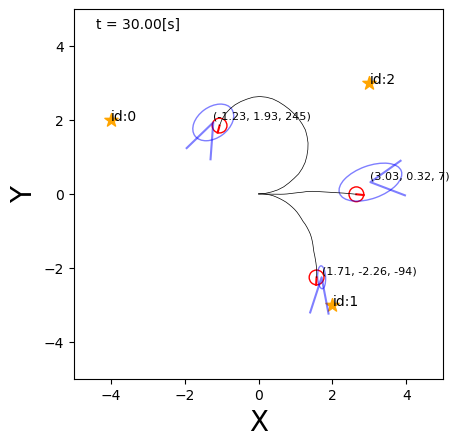

In [25]:
trial()